# Image Stitching (Python)

## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the Stitching Pairs of Images section of MP 3. In main function, we outline the required functionalities step by step. Feel free to make modifications on the starter code if it's necessary.

## Package installation
- `opencv <= 3.4.2`
- `numpy`
- `skimage`
- `scipy`

# Common imports

In [1]:
import numpy as np
import scipy
import skimage
import skimage.io
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
from heapq import *
import itertools
import random
from skimage.transform import *

In [2]:
cv2.__version__

'3.4.2'

# Helper functions

In [2]:
def imread(fname):
    """
    read image into np array from file
    """
    return skimage.io.imread(fname)

def imread_bw(fname):
    """
    read image as gray scale format
    """
    return cv2.cvtColor(imread(fname), cv2.COLOR_BGR2GRAY)

def imshow(img):
    """
    show image
    """
    skimage.io.imshow(img)
    
def get_sift_data(img):
    """
    detect the keypoints and compute their SIFT descriptors with opencv library
    """
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    plot the match between two image according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')
    
def plot_panorama(ax, img):
    ax.set_aspect('equal')
    ax.imshow(img, cmap='gray')
    ax.axis('off')

# Your implementations

In [3]:
def get_best_matches(img1, img2, num_matches):
    kp1, des1 = get_sift_data(img1)
    kp2, des2 = get_sift_data(img2)
    kp1, kp2 = np.array(kp1), np.array(kp2)
    
    # Find distance between descriptors in images
    dist = scipy.spatial.distance.cdist(des1, des2, 'sqeuclidean')
    
    # Write your code to get the matches according to dist
    # <YOUR CODE>
    # n1, n2 = dist.shape
    # at this time, we have a n1 by n2 matrix where dist[i][j] represents the distance between kp1[i] and kp2[j]
    # in this example, we want to find the lowest distance for the first num_matches pairs
    # we need to use a max_heap
    max_heap = []
    counter = itertools.count()
    # first put num_matches element into pq
    n1, n2 = dist.shape
###################
#     for i in range(n1):
#         for j in range(n2):
#             # if this is the first num_matches pairs, push them into heap
#             if (i * n2 + j < num_matches):
#                 heappush(max_heap, (-dist[i][j], -next(counter), (kp1[i], kp2[j])))
#             # else, we compare the peek of the heap and the new element
#             # if the new coming element is smaller than the peek, we need to pop from heap and add new element
#             else:
#                 cur_score = max_heap[0][0]
#                 if (-dist[i][j] > cur_score):
#                     heapreplace(max_heap, (-dist[i][j], -next(counter), (kp1[i], kp2[j])))
#####################

    # now the max_heap stores the num_matches pairs
    data = []
    dist_f = dist.reshape(-1,)
    idx = np.argpartition(dist_f, num_matches)
    for index in idx[:num_matches]:
        i = index // n2
        j = index % n2
        x1, y1 = kp1[i].pt
        x2, y2 = kp2[j].pt
        data.append([x1, y1, x2, y2])
    return np.array(data)
    
    
    
#     # now the max_heap stores the num_matches pairs
#     data = []
#     for i in range(len(max_heap)):
#         p1, p2 = max_heap[i][2]
#         x1, y1 = p1.pt
#         x2, y2 = p2.pt
#         data.append([x1, y1, x2, y2])
    
#     return np.array(data), kp1, kp2, dist



def ransac(data, threshold=10, iterations=10):
    """
    write your ransac code to find the best model, inliers, and residuals
    """
    # <YOUR CODE>
    # we have img1 and img2 together with the coordincate of their matches
    # now we want to find a transformation that have most number of inliers
    # for each computation:
    # we need to find four random points from matches, find the transformation and find the number of inliers
    num_matches, _ = data.shape
    max_inlier = 0
    best_T = None
    new_data = None
    residue = 0
    cur_pairs_list = [x for x in range(num_matches)]
    for it in range(iterations):
        A = None
        random.shuffle(cur_pairs_list)
        # construct the homography function
        # Ah = 0, A has size 8 x 9 and h has size 9 x 1
        # A is known and h is unknown and is the transformation we want
        # A = [0.T,    x_i.T, -y_i'*x_i.T]
        #     [x_i.T,    0.T, -x_i'*x_i.T]
        # i from 0 to 3 (we pick 4 points per iteration)
        # pair_i = data[i, :]
        for i in range(4):
            x1, y1, x2, y2 = data[cur_pairs_list[i], :]
            if i == 0:
                A = np.array([[0,   0, 0, x1, y1, 1, -y2*x1, -y2*y1, -y2],
                              [x1, y1, 1,  0,  0, 0, -x2*x1, -x2*y1, -x2]])
            else:
                new_A = np.array([[0,   0, 0, x1, y1, 1, -y2*x1, -y2*y1, -y2],
                                  [x1, y1, 1,  0,  0, 0, -x2*x1, -x2*y1, -x2]])
                A = np.vstack((A, new_A))
        
        # solve for linear equation
        u, s, vh = np.linalg.svd(A)
        h = vh[-1:].reshape(3, 3)
        # h /= h[2][2]
        if np.linalg.matrix_rank(h) < 3: 
            continue
        # after solving h, we need to find the inlier numbers of all matches pairs
        # ground truth (x2, y2) are data[:, 2:4]
        # estimate (x2, y2) are h @ data[:, 0:2].T (append 1 to the last row)
        data_from_1 = np.vstack((data[:, 0:2].T, np.ones((1, num_matches))))
        estimate_data = h @ data_from_1
        estimate_data = estimate_data[0:2, :] / estimate_data[2:3, :]
        # find the distance between estimate_data and ground truth
        diff = np.linalg.norm(estimate_data - data[:, 2:4].T, axis=0)**2
        inlier_residue = list(filter(lambda x: (x < threshold), diff))
        inlier_count = len(inlier_residue)
        # update best_T and count
        if inlier_count > max_inlier:
            max_inlier = inlier_count
            best_T = h
            residue = inlier_residue
            new_data = data[np.where(diff < threshold)]
            
    return best_T, new_data, max_inlier, residue


def compute_homography(img1, img2, h):
    """
    write your code to compute homography according to the matches
    """
    # <YOUR CODE>
    # h is the transformation if fixed img2, how img1 is transformed
    # first find the range of image indices
    height1, width1 = img1.shape[0:2]
    height2, width2 = img2.shape[0:2]
    corners1 = np.array([[0, 0, 1], [0, height1-1, 1], [width1-1, height1-1, 1], [width1-1, 0, 1]]).T
    corners2 = np.array([[0, 0, 1], [0, height2-1, 1], [width2-1, height2-1, 1], [width2-1, 0, 1]]).T
    new_corners1 = h @ corners1
    new_corners1 = new_corners1[0:2, :] / new_corners1[2:3, :]
    # find the range of the new_corners
    xmin1, xmax1 = np.min(new_corners1[0, :]), np.max(new_corners1[0, :])
    ymin1, ymax1 = np.min(new_corners1[1, :]), np.max(new_corners1[1, :])
    # now the image should range from xmin to width2, from ymin to height2
    yrange = np.ceil(np.maximum(height2, ymax1) - np.minimum(ymin1, height2))
    xrange = np.ceil(np.maximum(width2, xmax1) - np.minimum(xmin1, height2))
    # now we know we need to do a translation to the image
    xshift = -xmin1
    yshift = -ymin1
    affine = np.array([[1, 0, xshift],
                       [0, 1, yshift],
                       [0, 0,      1]])
    h1 = affine @ h
    h2 = affine
      
    img1_warped = warp(img1, np.linalg.inv(h1), output_shape=(yrange, xrange))
    img2_warped = warp(img2, np.linalg.inv(h2), output_shape=(yrange, xrange))

    fig1, ax1 = plt.subplots(figsize=(20,10))
    plot_panorama(ax1, img1_warped)
    fig2, ax2 = plt.subplots(figsize=(20,10))
    plot_panorama(ax2, img2_warped)
    return img1_warped, img2_warped
    

def warp_images(img1, img2):
    """
    write your code to stitch images together according to the homography
    """
    # <YOUR CODE>
    # we are given two images, we need to warp them together
    # assume we are given color images, which have 3 color channels
    # img1 and img2 should have the same size
    height, width = img1.shape[0:2]
    warp_image = np.zeros_like(img1)
    for i in range(height):
        for j in range(width):
            for c in range(3):
                if (img1[i, j, c] == 0):
                    warp_image[i, j, c] = img2[i, j, c]
                elif (img2[i, j, c] == 0):
                    warp_image[i, j, c] = img1[i, j, c]
                else:
                    warp_image[i, j, c] = 0.5 * (img1[i, j, c] + img2[i, j, c])
    
    fig, ax = plt.subplots(figsize=(20,10))
    plot_panorama(ax, warp_image)
    return warp_image

# Main functions

In [4]:
# load images
img1 = imread('./data/Q1/stitch/left.jpg')
img2 = imread('./data/Q1/stitch/right.jpg')
img1_bw = imread_bw('./data/Q1/stitch/left.jpg')
img2_bw = imread_bw('./data/Q1/stitch/right.jpg')

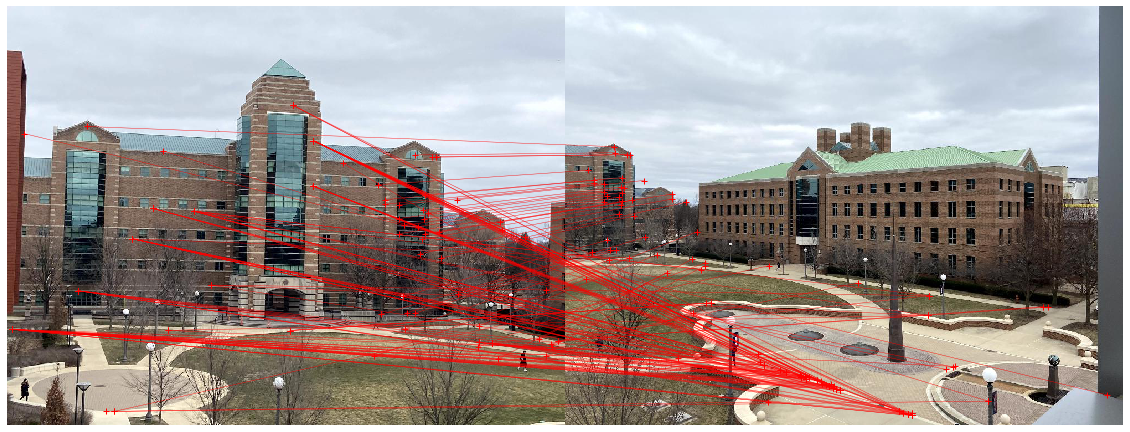

In [5]:
# part (c) compute and display the initial SIFT matching result
data = get_best_matches(img1, img2, 150)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, data)
fig.savefig('sift_match.png', bbox_inches='tight')

[[-1.61190701e-03 -3.38025688e-05  9.98929981e-01]
 [-3.14645600e-04 -1.44720958e-03  4.61746876e-02]
 [-9.67179192e-07 -2.13988746e-07 -1.41348275e-03]]
Average residual: 0.9957930611287623
Inliers: 33


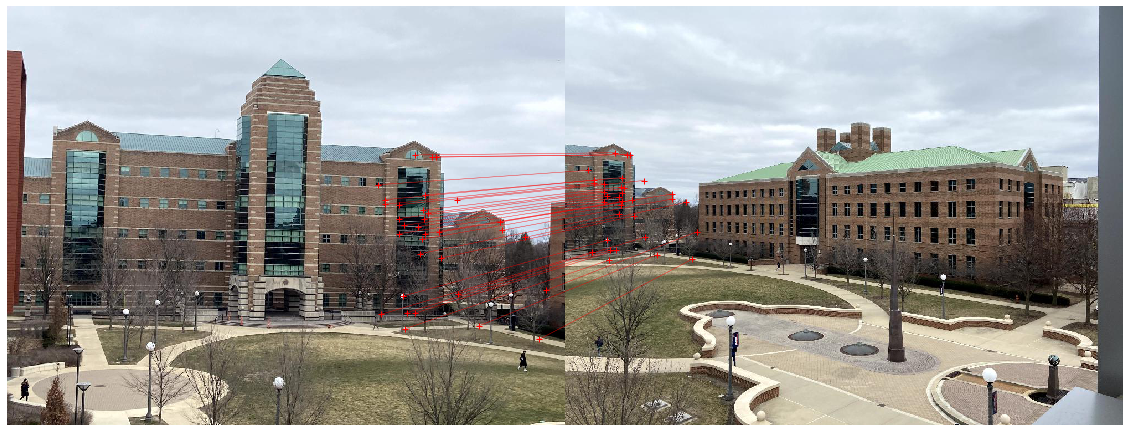

In [7]:
# part (d) performn RANSAC to get the homography and inliers, 
# display the inlier matching, report the average residual
# <YOUR CODE>
best_T, new_data, max_inlier, residue = ransac(data, threshold=5, iterations=5000)
print(best_T)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, new_data)
print("Average residual:", np.average(residue))
print("Inliers:", max_inlier)
# fig.savefig('ransac_match.pdf', bbox_inches='tight')

In [8]:
fig.savefig('ransac_match.pdf', bbox_inches='tight')

True

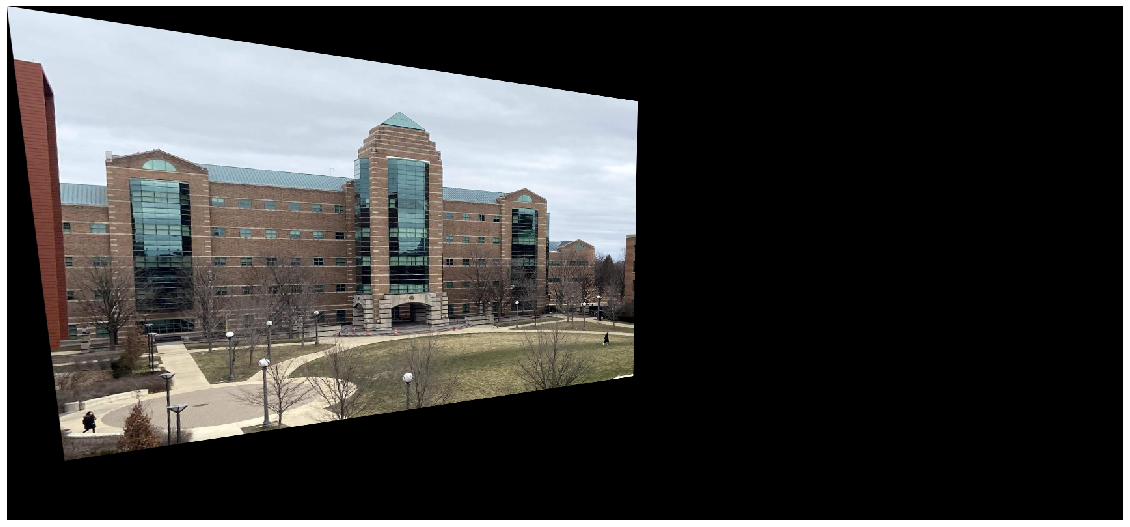

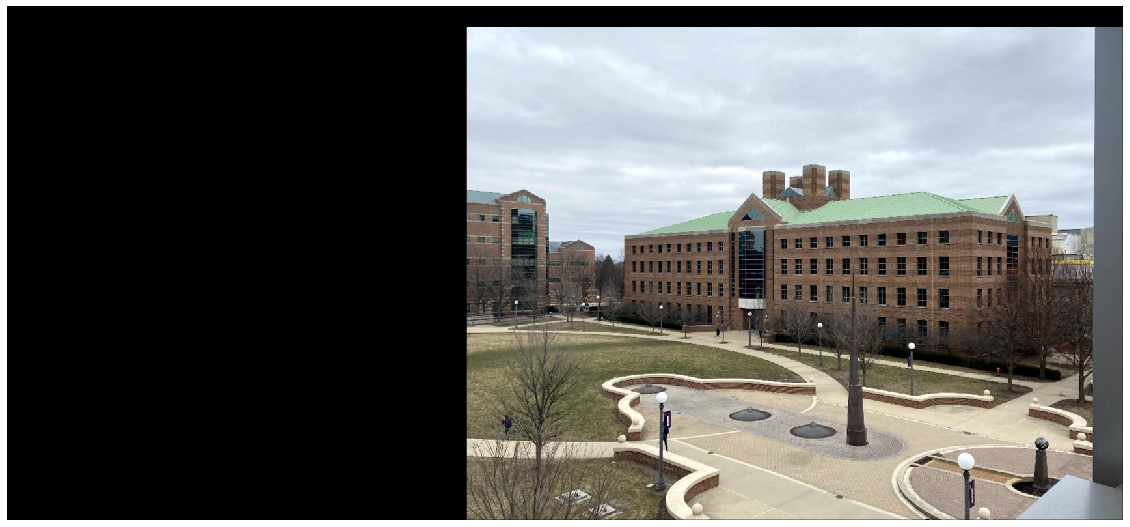

In [9]:
img1_warped, img2_warped = compute_homography(img1, img2, best_T)
cv2.imwrite('stitched_images1.jpg', img1_warped[:,:,::-1]*255., 
            [int(cv2.IMWRITE_JPEG_QUALITY), 90])
cv2.imwrite('stitched_images2.jpg', img2_warped[:,:,::-1]*255., 
            [int(cv2.IMWRITE_JPEG_QUALITY), 90])

True

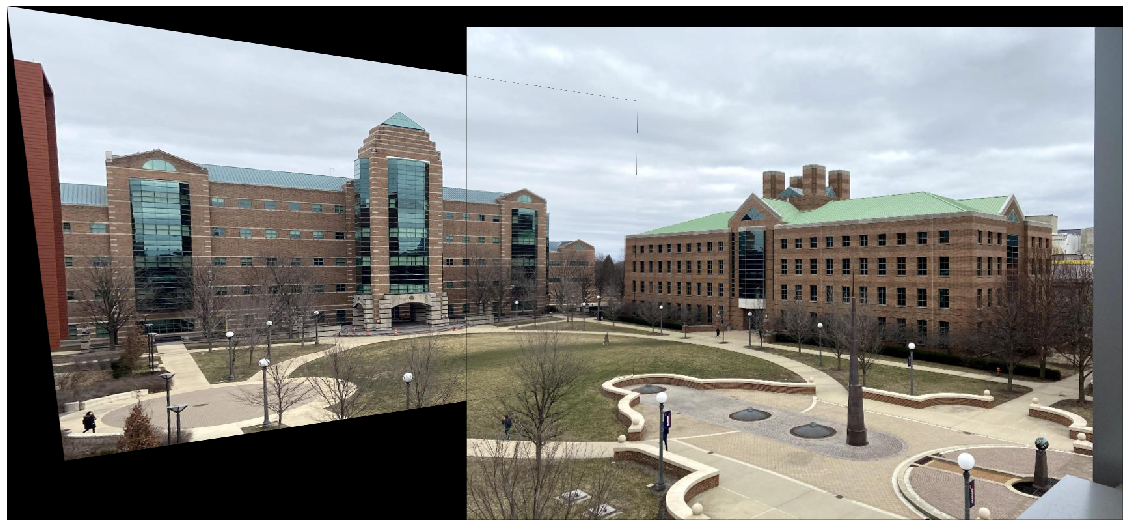

In [10]:
warp_image = warp_images(img1_warped, img2_warped)
# part (e) warp images to stitch them together, 
# display and report the stitching results
# <YOUR CODE>
cv2.imwrite('stitched_images.jpg', warp_image[:,:,::-1]*255., 
            [int(cv2.IMWRITE_JPEG_QUALITY), 90])